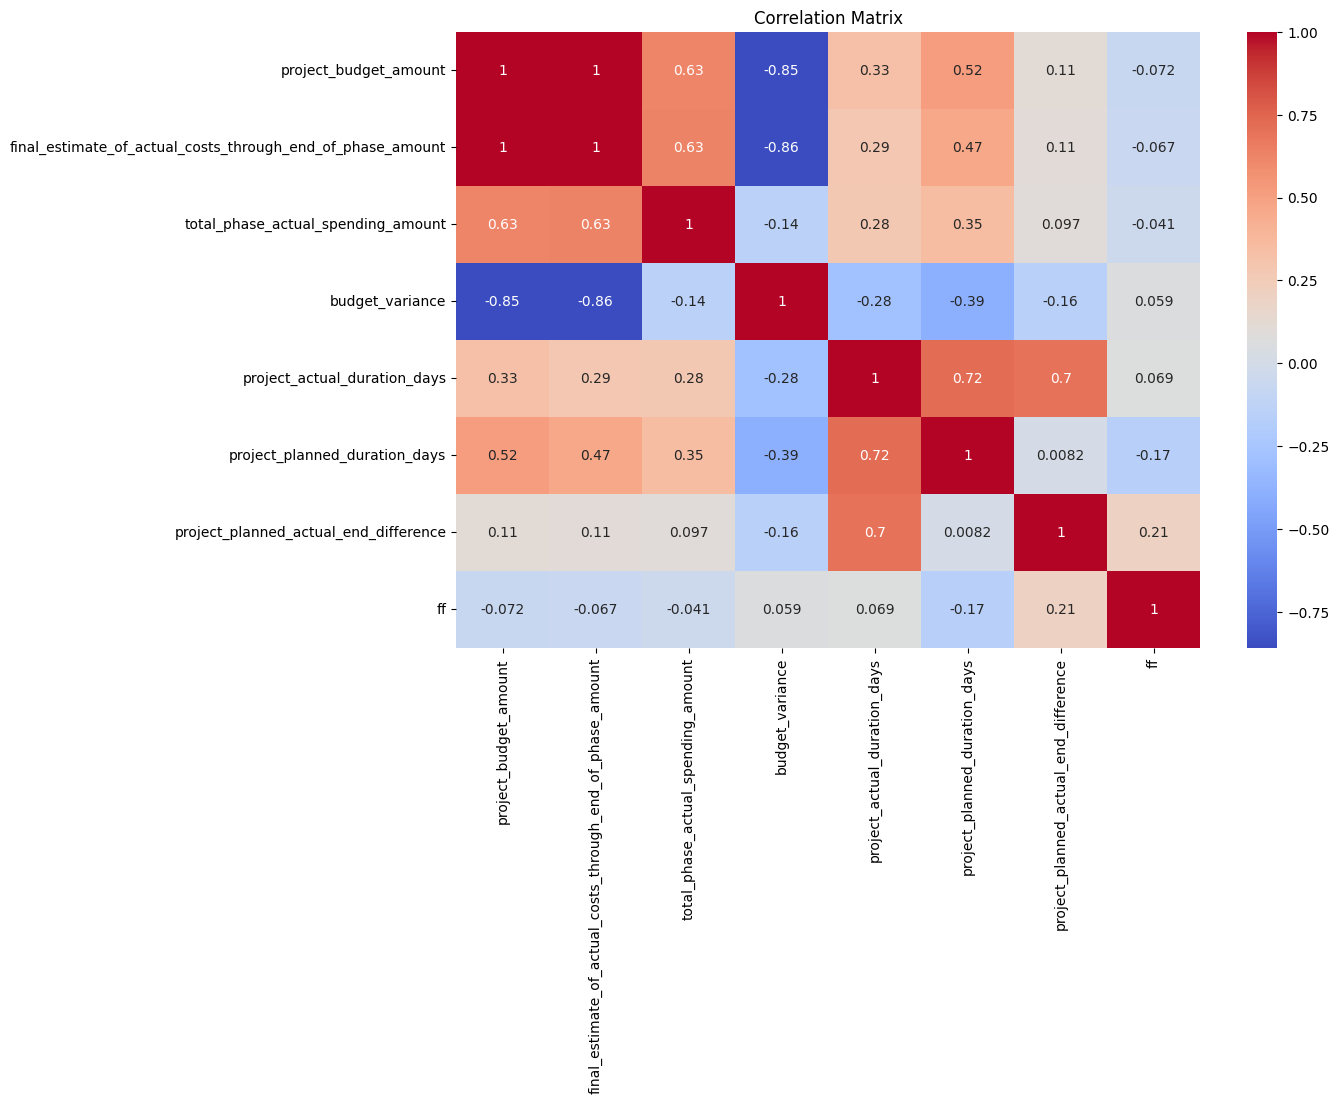

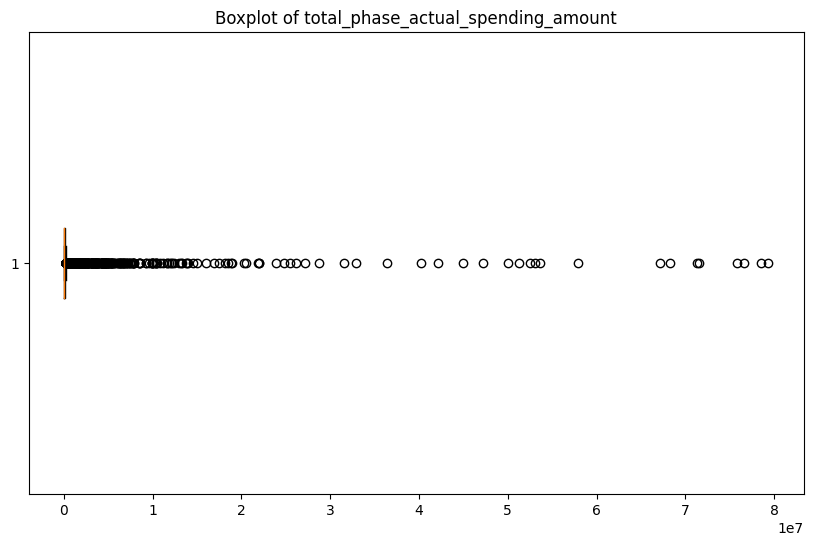

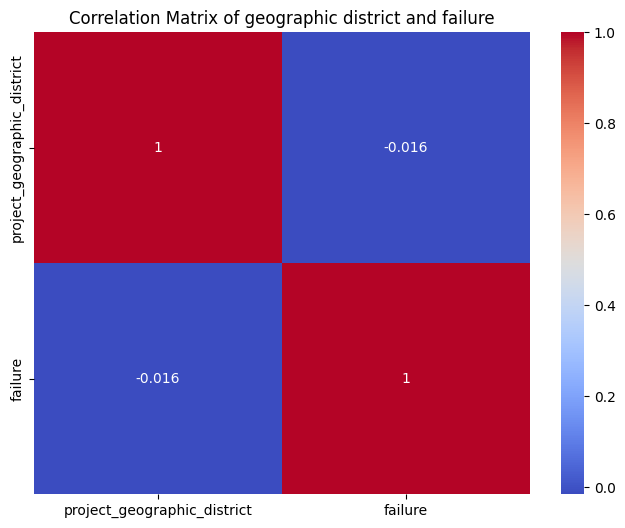

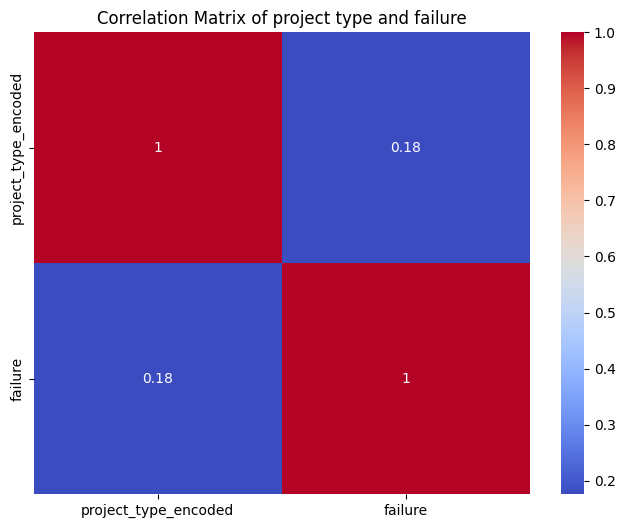

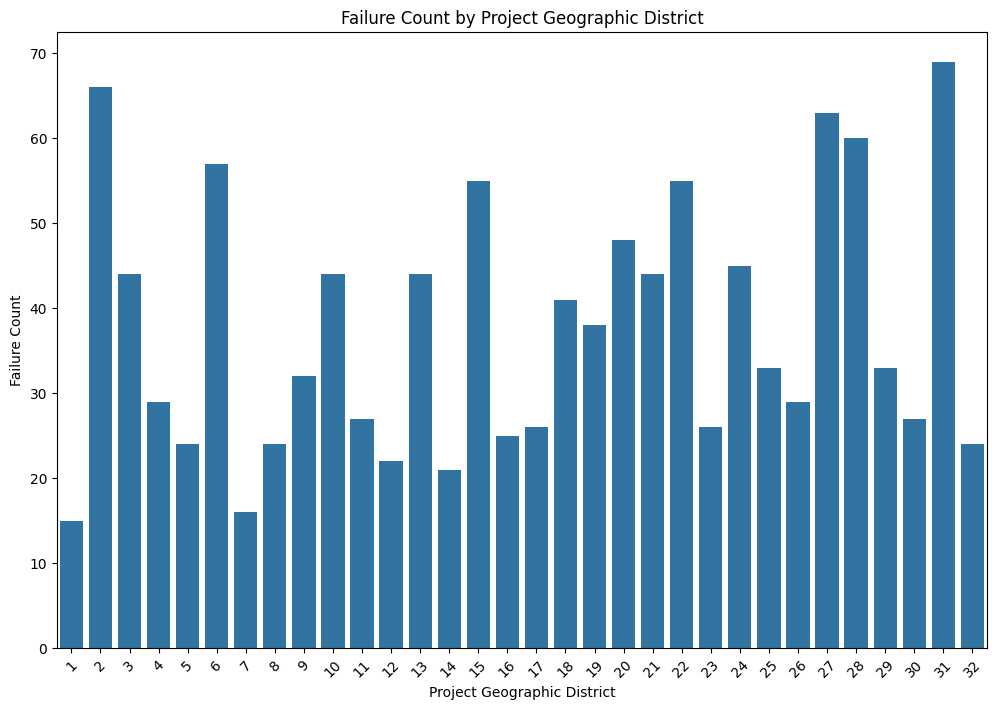

  project_phase_actual_start_date project_phase_actual_end_date duration
0                      2016-07-07                           NaT 629 days
1                      2016-07-07                           NaT 629 days
2                      2017-07-27                    2017-08-03   7 days
3                      2017-08-04                           NaT 185 days
4                             NaT                           NaT      NaT
5                             NaT                           NaT      NaT
6                      2017-05-15                    2017-09-14 122 days
7                      2017-05-15                    2017-09-14 122 days
8                      2016-08-02                    2017-02-13 195 days
9                      2017-05-15                    2017-12-18 217 days
Unnamed: 0                                                       0
project_geographic_district                                      0
project_building_identifier                                    

<ipython-input-12-3bdca0c1efe5>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = df_clean[col].astype(np.int64) // 10**9
<ipython-input-12-3bdca0c1efe5>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = df_clean[col].astype(np.int64) // 10**9
<ipython-input-12-3bdca0c1efe5>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv("https://datasocibmproject.s3.ap-southeast-2.amazonaws.com/structured_data/capital_project_schedules_and_budgets_1.csv")

# 1. Data Cleaning and Preparation
df.drop_duplicates(inplace=True)

# Converting dates into Datetime format
date_columns = ['project_phase_actual_start_date', 'project_phase_planned_end_date', 'project_phase_actual_end_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Calculate duration
df['duration'] = df['project_phase_actual_end_date'].combine_first(df['project_phase_planned_end_date']) - df['project_phase_actual_start_date']

# Create binary column for 'failure'
df['ff'] = 0
df.loc[df['failure'] == True, 'ff'] = 1

# Label encode the 'project_type' column
le = LabelEncoder()
df['xx'] = le.fit_transform(df['project_type'].astype(str))

# Convert numeric columns
numeric_columns = ['project_budget_amount', 'final_estimate_of_actual_costs_through_end_of_phase_amount', 'total_phase_actual_spending_amount']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Create new column for budget variance
df['budget_variance'] = df['total_phase_actual_spending_amount'] - df['final_estimate_of_actual_costs_through_end_of_phase_amount']

# Calculate duration in days
df['project_actual_duration_days'] = (df['project_phase_actual_end_date'] - df['project_phase_actual_start_date']).dt.days
df['project_planned_duration_days'] = (df['project_phase_planned_end_date'] - df['project_phase_actual_start_date']).dt.days
df['project_planned_actual_end_difference'] = (df['project_phase_actual_end_date'] - df['project_phase_planned_end_date']).dt.days

# 2. EDA

# a. Correlation between failure and other numeric features
numeric_features = ['project_budget_amount', 'final_estimate_of_actual_costs_through_end_of_phase_amount', 'total_phase_actual_spending_amount', 'budget_variance', 'project_actual_duration_days', 'project_planned_duration_days', 'project_planned_actual_end_difference']
correlation_matrix = df[numeric_features + ['ff']].corr()

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# b. Distribution of total_phase_actual_spending_amount
plt.figure(figsize=(10, 6))
plt.boxplot(df['total_phase_actual_spending_amount'], vert=False)
plt.title('Boxplot of total_phase_actual_spending_amount')
plt.show()

# c. Correlation of geographic district and failure
district_vs_failure = df[['project_geographic_district', 'failure']]
district_failure_corr = district_vs_failure.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(district_failure_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of geographic district and failure')
plt.show()

# d. Correlation of project type and failure
df['project_type_encoded'] = pd.factorize(df['project_type'])[0]
project_type_vs_failure = df[['project_type_encoded', 'failure']]
project_type_failure_corr = project_type_vs_failure.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(project_type_failure_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of project type and failure')
plt.show()

# e. Failure Count by Project Geographic District
df_agg = df.groupby('project_geographic_district')['failure'].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=df_agg, x='project_geographic_district', y='failure')
plt.xlabel('Project Geographic District')
plt.ylabel('Failure Count')
plt.title('Failure Count by Project Geographic District')
plt.xticks(rotation=45)
plt.show()

# 3. Regression Analysis

# Defining features for regression analysis
features = ['project_phase_actual_start_date', 'project_phase_planned_end_date', 'xx', 'project_budget_amount',
            'final_estimate_of_actual_costs_through_end_of_phase_amount', 'total_phase_actual_spending_amount', 'ff']

df_clean = df.dropna(subset=features + ['duration'])

# Convert date columns to numeric values in seconds since epoch
for col in ['project_phase_actual_start_date', 'project_phase_planned_end_date']:
    df_clean[col] = df_clean[col].astype(np.int64) // 10**9

X = df_clean[features]
y = df_clean['duration'].dt.total_seconds()  # Convert duration to total seconds

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting linear regression model
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

# Predict the duration for the missing values
df_missing = df[df['duration'].isnull() & df['project_phase_actual_start_date'].notnull()]
for col in ['project_phase_actual_start_date', 'project_phase_planned_end_date']:
    df_missing[col] = df_missing[col].astype(np.int64) // 10**9

df_missing_features = df_missing[features].dropna()  # Ensure there are no NaNs in features
predicted_durations = lin_reg_model.predict(df_missing_features)

# Convert predicted durations from seconds to timedelta and fill missing duration
df.loc[df_missing_features.index, 'duration'] = pd.to_timedelta(predicted_durations, unit='s')

print(df[['project_phase_actual_start_date', 'project_phase_actual_end_date', 'duration']].head(10))

# Check for missing values
print(df.isnull().sum())

# Logistic Regression Analysis for Failure Prediction
independent_vars = ['project_phase_actual_start_date', 'project_phase_planned_end_date', 'project_phase_actual_end_date', 'xx', 'project_budget_amount', 'final_estimate_of_actual_costs_through_end_of_phase_amount', 'total_phase_actual_spending_amount']

df = df.dropna(subset=independent_vars + ['ff'])  # Drop rows with missing values in the required columns

# Convert date columns to numeric values in seconds since epoch
for col in date_columns:
    df[col] = df[col].astype(np.int64) // 10**9

X = df[independent_vars]
y = df['ff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logit_model = LogisticRegression(max_iter=1000)
logit_model.fit(X_train, y_train)

y_pred_logit = logit_model.predict(X_test)
logit_accuracy = accuracy_score(y_test, y_pred_logit)
print(f'Logit Model Accuracy: {logit_accuracy}')

# Get the coefficients and intercept
coefficients = logit_model.coef_[0]
intercept = logit_model.intercept_[0]

# Print coefficients
print("Intercept:", intercept)
print("Coefficients:", coefficients)


<ipython-input-13-6cd6b3d7d91d>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['duration'] = df_clean['duration'].dt.total_seconds()  # Convert duration to total seconds
<ipython-input-13-6cd6b3d7d91d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = df_clean[col].astype(np.int64) // 10**9
<ipython-input-13-6cd6b3d7d91d>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

Decision Tree Model Accuracy: 0.9287211740041929
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       431
           1       0.68      0.50      0.58        46

    accuracy                           0.93       477
   macro avg       0.81      0.74      0.77       477
weighted avg       0.92      0.93      0.92       477



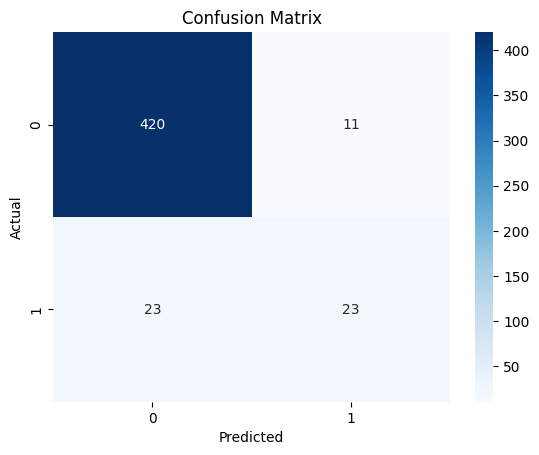

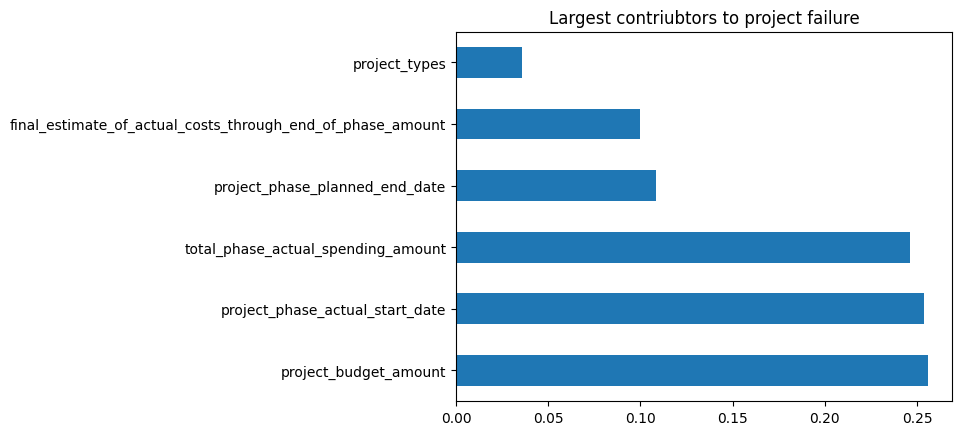

In [13]:
# Decision Tree Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Load dataset
df = pd.read_csv("https://datasocibmproject.s3.ap-southeast-2.amazonaws.com/structured_data/capital_project_schedules_and_budgets_1.csv")

# Remove duplicates
df.drop_duplicates(inplace=True)

# Create binary column for 'failure'
df['ff'] = 0
df.loc[df['failure'] == True, 'ff'] = 1

# Label encode the 'project_type' column
le = LabelEncoder()
df['project_types'] = le.fit_transform(df['project_type'].astype(str))

# Convert date columns to datetime format
date_columns = ['project_phase_actual_start_date', 'project_phase_planned_end_date', 'project_phase_actual_end_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Calculate duration using actual or planned end date
df['duration'] = df['project_phase_actual_end_date'] - df['project_phase_actual_start_date']

# Convert numeric columns
numeric_columns = ['project_budget_amount', 'final_estimate_of_actual_costs_through_end_of_phase_amount', 'total_phase_actual_spending_amount']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Define features
features = ['project_phase_actual_start_date', 'project_phase_planned_end_date', 'project_types', 'project_budget_amount',
            'final_estimate_of_actual_costs_through_end_of_phase_amount', 'total_phase_actual_spending_amount']

# Handle missing values in features and duration
df_clean = df.dropna(subset=features + ['duration'])
df_clean['duration'] = df_clean['duration'].dt.total_seconds()  # Convert duration to total seconds

# Convert date columns to numeric values in seconds since epoch
for col in date_columns:
    df_clean[col] = df_clean[col].astype(np.int64) // 10**9

# Define X and y
X = df_clean[features]
y = df_clean['ff']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the decision tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Decision Tree Model Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
feature_importances = pd.Series(dt_model.feature_importances_, index=features)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Largest contriubtors to project failure')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv("https://datasocibmproject.s3.ap-southeast-2.amazonaws.com/structured_data/capital_project_schedules_and_budgets_1.csv")

df.drop_duplicates()     # no duplicates

#initiate new column as all 0
df['ff'] = 0

# when failue is yes change value to 1
df.loc[df['failure'] == True, 'ff'] = 1

# handle missing val
def handle_date_conversion(date_str):
    try:
        return pd.to_datetime(date_str, format="%m/%d/%Y", errors='coerce')
    except Exception:
        return pd.NaT

# Apply the date conversion function to each date column
date_columns = ['project_phase_actual_start_date', 'project_phase_planned_end_date', 'project_phase_actual_end_date']
for col in date_columns:
    df[col] = df[col].apply(handle_date_conversion)

# turn project_budget_amount to numeric and handle missing value
df['project_budget_amount'] = pd.to_numeric(df['project_budget_amount'], errors='coerce')


# change type to numeric value
le = LabelEncoder()
df['xx'] = le.fit_transform(df['project_type'].astype(str))

# input
independent_vars = ['project_phase_actual_start_date', 'project_phase_planned_end_date', 'project_phase_actual_end_date', 'xx', 'project_budget_amount', 'final_estimate_of_actual_costs_through_end_of_phase_amount', 'total_phase_actual_spending_amount']

# drop row with null value in particular subset(inout set)
df = df.dropna(subset=independent_vars + ['ff'])  # Drop rows with missing values in the required columns

# change date to numeric values in seconds
df.loc[:, date_columns] = df[date_columns].apply(lambda x: x.astype(np.int64) // 10**9)

# use logit model
X = df[independent_vars]
y = df['ff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logit_model = LogisticRegression(max_iter=1000)
logit_model.fit(X_train, y_train)

y_pred_logit = logit_model.predict(X_test)
logit_accuracy = accuracy_score(y_test, y_pred_logit)
print(f'Logit Model Accuracy: {logit_accuracy}')
print()
print("==========")

# Get the coefficients and intercept
coefficients = logit_model.coef_[0]
intercept = logit_model.intercept_[0]

# Print coefficients
print("Intercept:", intercept)
print("Coefficients:", coefficients)



Logit Model Accuracy: 0.9140461215932913

Intercept: 2.0182890019303945e-12
Coefficients: [ 6.32538272e-08 -1.09050777e-07  4.46198316e-08  8.71065659e-11
 -2.05851136e-06  6.28607182e-07  8.68230624e-07]


In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("https://datasocibmproject.s3.ap-southeast-2.amazonaws.com/structured_data/capital_project_schedules_and_budgets_1.csv")

# Remove duplicates
df.drop_duplicates(inplace=True)

# Create binary column for 'failure'
df['ff'] = 0
df.loc[df['failure'] == True, 'ff'] = 1

# Label encode the 'project_type' column
le = LabelEncoder()
df['xx'] = le.fit_transform(df['project_type'].astype(str))

# Convert numeric columns
numeric_columns = ['project_budget_amount', 'final_estimate_of_actual_costs_through_end_of_phase_amount', 'total_phase_actual_spending_amount']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Ensure the date columns are in datetime format
df['project_phase_actual_start_date'] = pd.to_datetime(df['project_phase_actual_start_date'], errors='coerce')
df['project_phase_planned_end_date'] = pd.to_datetime(df['project_phase_planned_end_date'], errors='coerce')
df['project_phase_actual_end_date'] = pd.to_datetime(df['project_phase_actual_end_date'], errors='coerce')

# Calculate duration for all rows
df['duration'] = df['project_phase_actual_end_date'] - df['project_phase_actual_start_date']

# Handle missing values in features and duration
df_clean = df.dropna(subset=features + ['project_phase_actual_start_date', 'project_phase_actual_end_date'])

# Calculate duration for the cleaned dataframe
df_clean['duration'] = df_clean['project_phase_actual_end_date'] - df_clean['project_phase_actual_start_date']

# Convert date columns to numeric values in seconds since epoch
date_columns = ['project_phase_actual_start_date', 'project_phase_planned_end_date']
for col in date_columns:
    df_clean[col] = df_clean[col].astype(np.int64) // 10**9

# Define features
features = ['project_phase_actual_start_date', 'project_phase_planned_end_date', 'xx', 'project_budget_amount',
            'final_estimate_of_actual_costs_through_end_of_phase_amount', 'total_phase_actual_spending_amount']

# Define X and y
X = df_clean[features]
y = df_clean['duration'].dt.total_seconds()  # Convert duration to total seconds

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression model
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

# Select rows where duration is null
df_missing = df[df['duration'].isnull() & df['project_phase_actual_start_date'].notnull()]
for col in date_columns:
    df_missing[col] = pd.to_datetime(df_missing[col], errors='coerce').astype(np.int64) // 10**9

df_missing_features = df_missing[features].dropna()  # Ensure there are no NaNs in features
predicted_durations = lin_reg_model.predict(df_missing_features)

# Convert predicted durations from seconds to timedelta and fill missing duration
df.loc[df_missing_features.index, 'duration'] = pd.to_timedelta(predicted_durations, unit='s')

# Print results
print(df[['project_phase_actual_start_date', 'project_phase_actual_end_date', 'duration']].head(10))



  project_phase_actual_start_date project_phase_actual_end_date  \
0                      2016-07-07                           NaT   
1                      2016-07-07                           NaT   
2                      2017-07-27                    2017-08-03   
3                      2017-08-04                           NaT   
4                             NaT                           NaT   
5                             NaT                           NaT   
6                      2017-05-15                    2017-09-14   
7                      2017-05-15                    2017-09-14   
8                      2016-08-02                    2017-02-13   
9                      2017-05-15                    2017-12-18   

                     duration  
0 651 days 16:52:41.964339316  
1 615 days 08:09:19.116860412  
2             7 days 00:00:00  
3 177 days 10:04:58.101807136  
4                         NaT  
5                         NaT  
6           122 days 00:00:00  
7     

<ipython-input-15-5ecd0beab3f7>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['duration'] = df_clean['project_phase_actual_end_date'] - df_clean['project_phase_actual_start_date']
<ipython-input-15-5ecd0beab3f7>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = df_clean[col].astype(np.int64) // 10**9
<ipython-input-15-5ecd0beab3f7>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [21]:
import pandas as pd

# Load dataset
df = pd.read_csv("https://datasocibmproject.s3.ap-southeast-2.amazonaws.com/structured_data/capital_project_schedules_and_budgets_1.csv")

# Identify date columns
date_columns = ['project_phase_actual_start_date', 'project_phase_planned_end_date', 'project_phase_actual_end_date']

# Function to check for invalid date values
def check_invalid_dates(date_series):
    # Convert to datetime, count errors (invalid dates)
    invalid_dates = pd.to_datetime(date_series, errors='coerce').isna() & (date_series != '') & (date_series != 'PNS') & (date_series != 'DOES')
    return invalid_dates

# Check for invalid dates across all date columns
invalid_date_rows = df[date_columns].apply(check_invalid_dates).any(axis=1)

# Check for blank date values across all date columns
blank_date_rows = df[date_columns].isna().any(axis=1)

# Check for 'PNS' or 'DOES' in date columns
pns_date_rows = (df[date_columns] == 'PNS').any(axis=1)
does_date_rows = (df[date_columns] == 'DOES').any(axis=1)

# Total rows with invalid, blank, 'PNS', or 'DOES' date values
invalid_or_special_date_rows = (invalid_date_rows | blank_date_rows | pns_date_rows | does_date_rows)

# Count the number of such rows
num_invalid_or_special_date_rows = invalid_or_special_date_rows.sum()
num_invalid_or_special_date_rows



5757

In [23]:
import pandas as pd

# Load dataset
df = pd.read_csv("https://datasocibmproject.s3.ap-southeast-2.amazonaws.com/structured_data/capital_project_schedules_and_budgets_1.csv")

# Identify date columns
date_columns = ['project_phase_actual_start_date', 'project_phase_planned_end_date', 'project_phase_actual_end_date']

# Define a list of known non-date values
non_date_values = ['PNS', 'DOES', 'IEH', 'DIIT', 'FTK', 'DOEL', 'IEH', '', 'DCAS', 'FY']

# Function to check for non-date values
def is_non_date(value):
    # Convert to datetime, check if conversion fails or value is in non_date_values list
    try:
        pd.to_datetime(value, errors='raise')
        return False
    except:
        return value in non_date_values or value == '' or pd.isna(value)

# Apply the function to each date column and combine the results
non_date_rows = df[date_columns].applymap(is_non_date).any(axis=1)

# Count the number of rows with non-date values
num_non_date_rows = non_date_rows.sum()
num_non_date_rows



4189

In [ ]:
!pip install ibm_watsonx_ai.foundation_models
!pip install ibm_watsonx_ai.metanames
!pip install dotenv

from ibm_watsonx_ai.foundation_models import Model
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from dotenv import load_dotenv
import os

load_dotenv()
project_id = os.getenv('PROJECT_ID')
api_key=os.getenv('GENAI_API_KEY')
url=os.getenv('GENAI_URL')

# Modify your prompt below.
prompt = '''
<|begin_of_text|><|start_header_id|>user<|end_header_id|>
Why is the sky blue?
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
'''

# Tokens can be thought of as part words - almost like syllables.
# Larger MAX_NEW_TOKENS will allow the models to generate longer responses.
# Each model has a unique context window for tokens - for llama3 it is 8000 tokens.
generate_params = {
            GenParams.MAX_NEW_TOKENS: 300
        }

model = Model(
    model_id="ibm/granite-13b-chat-v2",
    params=generate_params,
    credentials={
        "apikey": f"{api_key}",
        "url": f"{url}"
    },
    project_id=project_id
)

generated_response = model.generate(prompt=prompt)
print(generated_response['results'][0]['generated_text'])

ERROR: Could not find a version that satisfies the requirement ibm_watsonx_ai.foundation_models (from versions: none)
ERROR: No matching distribution found for ibm_watsonx_ai.foundation_models
ERROR: Could not find a version that satisfies the requirement ibm_watsonx_ai.metanames (from versions: none)
ERROR: No matching distribution found for ibm_watsonx_ai.metanames
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


ModuleNotFoundError: No module named 'dotenv'